In [1]:
#custom fm test
import networkx as nx
from regraph import NXGraph, Rule, plot_rule

#from rdfobj.query import GraphTransformer,QueryBuilder,OrNode,AndNode,EntityNode
from biopax import *
 
from biopax.utils import gen_utils
from rdfobj.toolbox_sparql import Toolbox
from rdfobj.rule import GraphTransformer,RuleGenerator 


In [2]:
# Define the left-hand side of the rule
lh_g = NXGraph()

lh_g.add_nodes_from(
    [
        'LH1',
        ('LH2', {'age': 15, 'gender': 'male'}),
        ('LH3', {'age': 40, 'gender': 'female'}),
        ('LH4', {'age': 55, 'gender': 'male'}),
])

# Add a list of edges, optionally with attributes
lh_g.add_edges_from([
    ("LH1", "LH2"),
    ("LH2", "LH3", {"type": "parent", "since": 1993}),
    ("LH1", "LH4", {"type": "friend", "since": 1985}),
    ("LH4", "LH3", {"type": "parent", "since": 1992}),
])

#lh_g.add_nodes_from(["LH1", "LH2", "LH3"])
#lh_g.add_edges_from([("LH1", "LH2"), ("LH2", "LH3")])
lh_g.update_node_attrs("LH1",{'age': 25, 'gender': 'female'})


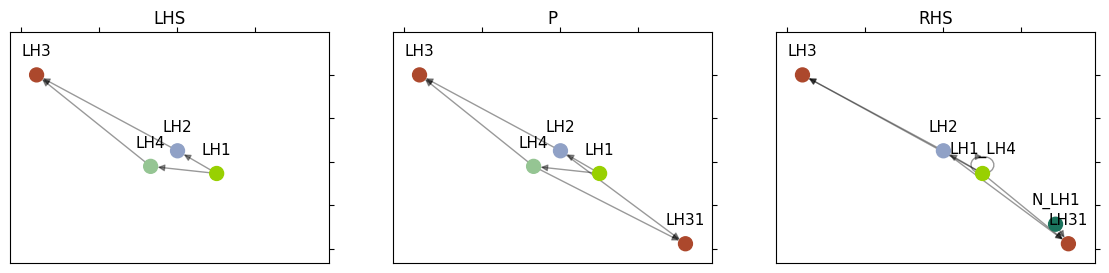

CLONE LH3 AS LH31.
MERGE [LH4, LH1] AS 'LH1_LH4'.
ADD_NODE N_LH1 {}.
ADD_EDGE N_LH1 LH31 {}.
ADD_NODE_ATTRS LH1_LH4 {'age': {25, 55}, 'gender': {'female', 'male'}}.
ADD_EDGE_ATTRS LH1_LH4 LH1_LH4 {'type': {'friend'}, 'since': {1985}}.
ADD_EDGE_ATTRS LH1_LH4 LH31 {'type': {'parent'}, 'since': {1992}}.
ADD_EDGE_ATTRS LH1_LH4 LH3 {'type': {'parent'}, 'since': {1992}}.

----lhs---
[('LH1', 'LH2'), ('LH1', 'LH4'), ('LH2', 'LH3'), ('LH4', 'LH3')]
['LH1', 'LH2', 'LH3', 'LH4']
----p---
[('LH1', 'LH2'), ('LH1', 'LH4'), ('LH2', 'LH3'), ('LH2', 'LH31'), ('LH4', 'LH3'), ('LH4', 'LH31')]
['LH1', 'LH2', 'LH3', 'LH4', 'LH31']
----rhs---
[('LH2', 'LH3'), ('LH2', 'LH31'), ('N_LH1', 'LH31'), ('LH1_LH4', 'LH1_LH4'), ('LH1_LH4', 'LH31'), ('LH1_LH4', 'LH2'), ('LH1_LH4', 'LH3')]
['LH2', 'LH3', 'LH31', 'N_LH1', 'LH1_LH4']
Graph(5 nodes, 7 edges)
LH1_LH4
{'age': {25, 55}, 'gender': {'female', 'male'}}


In [3]:




#print(lh_g._graph.nodes.data())
###nx.add_node_attribute()


rule1 = Rule.from_transform(lh_g)
# `inject_clone_node` returns the IDs of the newly created
# clone in P and RHS
p_clone, rhs_clone2 = rule1.inject_clone_node("LH3")
rule1.inject_add_node("N_LH1")
rule1.inject_add_edge("N_LH1", rhs_clone2)


merge_node = rule1.inject_merge_nodes(["LH1", "LH4"])

#rule1.inject_remove_node("LH1")
plot_rule(rule1)
print(rule1.to_commands())

print("----lhs---")
print(rule1.lhs.edges())
print(rule1.lhs.nodes())

print("----p---")
print(rule1.p.edges())
print(rule1.p.nodes())

print("----rhs---")
print(rule1.rhs.edges())
print(rule1.rhs.nodes())


 
g=rule1.rhs
print(g)
print(merge_node)
v=g.get_node(merge_node) 
print("warning : how to merge attributes ?")
print("warning : how to remove self cycle ?")
print(v)
 
    
    
### todo : implemente spaim transform here
##

In [4]:
##########################graph pattern matching 
## can be using to create user defined queries (witout sparql), in memory, by chunck...
# can be used to  rewrite the graph (in memory, by chunck ....)
#  we can generate sparql from this (in some case sure , but all cases ????)
# no > < only ==
# AND by default, no operator OR . for OR add 2 patterns
pattern = NXGraph()
pattern.add_nodes_from(["x", "y", "z"])
pattern.add_edges_from([
    ("x", "y"),
    ("z", "y")
])
pattern.add_edge_attrs("x", "y", {"type": "parent"})
pattern.add_edge_attrs("z", "y", {"type": "parent"})


pattern.add_node_attrs("x", {"gender": "female"})


instances = g.find_matching(pattern)
 

# perhaps find_matching not necessary ???
#need to convert biopax obj to  NXGraph



gt=GraphTransformer()

def rule1(gr:NXGraph,nodeids,gtr:GraphTransformer):
 #######input nodes labelling   
 x=nodeids['x']
 y=nodeids['y']
 z=nodeids['z']
 ###### transformation  rule   
 rule1 = Rule.from_transform(gr) # =>mask
 p_clone, clone1 = rule1.inject_clone_node(x)#=> clone_node
 nnid="N_"+str(x)
 rule1.inject_add_node(nnid)# add_node=> return nnid
 rule1.inject_add_edge(nnid,  clone1)# add_edge
 merge_node = rule1.inject_merge_nodes([x,y])#merge node 
 ##################
 ##output definition
 rhs=rule1.rhs
    
 tagged_nodes=[z,nnid,merge_node,clone1]  
 tagged_edges=[[nnid,  clone1]]  
    
 gtr.tagRuleOutput(rhs,tagged_nodes,tagged_edges)       
 return rhs


 

rw_g = NXGraph()


# now apply rewrite rule to generate a new graph
lhs=g
for inst in instances:
    print("inst: ",inst)
    rhs=rule1(lhs,inst,gt)
    print(rhs.edges())
    print(rhs.nodes())
    #we create a new graph  
    gt.addRuleOutput(rhs,rw_g)   
    print("--------")
print("-----------rw_g------------------")    
print(rw_g.edges())
print(rw_g.nodes())

L1.1
L1.2
L1.3
L1.4
L1.5
L1.78
inst:  {'x': 'LH1_LH4', 'y': 'LH31', 'z': 'LH2'}
[('LH2', 'LH3'), ('LH2', 'LH1_LH4_LH31'), ('N_LH1', 'LH1_LH4_LH31'), ('LH1_LH41', 'LH2'), ('LH1_LH41', 'LH3'), ('LH1_LH41', 'LH1_LH41'), ('LH1_LH41', 'LH1_LH4_LH31'), ('N_LH1_LH4', 'LH1_LH41'), ('LH1_LH4_LH31', 'LH1_LH4_LH31'), ('LH1_LH4_LH31', 'LH2'), ('LH1_LH4_LH31', 'LH1_LH41'), ('LH1_LH4_LH31', 'LH3')]
['LH2', 'LH3', 'N_LH1', 'LH1_LH41', 'N_LH1_LH4', 'LH1_LH4_LH31']
   add node---- LH2
   add node---- LH1_LH41
   add node---- N_LH1_LH4
   add node---- LH1_LH4_LH31
   add edge---- N_LH1_LH4->LH1_LH41
--------
inst:  {'x': 'LH1_LH4', 'y': 'LH3', 'z': 'LH2'}
[('LH2', 'LH31'), ('LH2', 'LH1_LH4_LH3'), ('N_LH1', 'LH31'), ('LH1_LH41', 'LH2'), ('LH1_LH41', 'LH1_LH41'), ('LH1_LH41', 'LH31'), ('LH1_LH41', 'LH1_LH4_LH3'), ('N_LH1_LH4', 'LH1_LH41'), ('LH1_LH4_LH3', 'LH1_LH4_LH3'), ('LH1_LH4_LH3', 'LH31'), ('LH1_LH4_LH3', 'LH1_LH41'), ('LH1_LH4_LH3', 'LH2')]
['LH2', 'LH31', 'N_LH1', 'LH1_LH41', 'N_LH1_LH4', 'LH1_LH4

In [5]:
##see https://github.com/Kappa-Dev/ReGraph/blob/bb148a7cbd94e87f622443263e04c3fae2d4d00b/regraph/backends/networkx/graphs.py
"""Find matching of a pattern in a graph.
        This function takes as an input a graph and a pattern, optionally,
        it also takes a collection of nodes specifying the subgraph of the
        original graph, where the matching should be searched in, then it
        searches for a matching of the pattern inside of the graph (or induced
        subragh), which corresponds to solving subgraph matching problem.
        The matching is defined by a map from the nodes of the pattern
        to the nodes of the graph such that:
        * edges are preserved, i.e. if there is an edge between nodes `n1`
          and `n2` in the pattern, there is an edge between the nodes of
          the graph that correspond to the image of `n1` and `n2`,
          moreover, the attribute dictionary of the edge between `n1`
          and `n2` is the subdictiotary of the edge it corresponds to
          in the graph;
        * the attribute dictionary of a pattern node is a subdictionary of
          its image in the graph;
        Uses `networkx.isomorphism.(Di)GraphMatcher` class, which implements
        subgraph matching algorithm.
        In addition, two parameters `graph_typing` and `pattern_typing`
        can be specified. They restrict the space of admisible solutions
        by checking if an isomorphic subgraph found in the input graph respects
        the provided pattern typings according to the specified graph typings.
        Parameters
        ----------
        graph : nx.(Di)Graph
        pattern : nx.(Di)Graph
            Pattern graph to search for
        nodes : iterable, optional
            Subset of nodes to search for matching
        graph_typing : dict of dict, optional
            Dictionary defining typing of graph nodes
        pattern_typing : dict of dict, optional
            Dictionary definiting typing of pattern nodes
        Returns
        -------
        instances : list of dict's
            List of instances of matching found in the graph, every instance
            is represented with a dictionary where keys are nodes of the
            pattern, and values are corresponding nodes of the graph.
        """

"Find matching of a pattern in a graph.\n        This function takes as an input a graph and a pattern, optionally,\n        it also takes a collection of nodes specifying the subgraph of the\n        original graph, where the matching should be searched in, then it\n        searches for a matching of the pattern inside of the graph (or induced\n        subragh), which corresponds to solving subgraph matching problem.\n        The matching is defined by a map from the nodes of the pattern\n        to the nodes of the graph such that:\n        * edges are preserved, i.e. if there is an edge between nodes `n1`\n          and `n2` in the pattern, there is an edge between the nodes of\n          the graph that correspond to the image of `n1` and `n2`,\n          moreover, the attribute dictionary of the edge between `n1`\n          and `n2` is the subdictiotary of the edge it corresponds to\n          in the graph;\n        * the attribute dictionary of a pattern node is a subdictionary of

In [6]:


    
def rule1refact(rg:RuleGenerator):
  #######input nodes labelling 
  nodeids=rg.nodeIds()   
  x=nodeids['x']
  y=nodeids['y']
  z=nodeids['z']  

  ###### transformation  rule   
  p_clone, clone1 =rg.clone_node(x)
  nnid=rg.add_node()
  rg.add_edge(nnid,  clone1)   
  merge_node = rg.merge_node(x,y) 
  ##output definition    
  tagged_nodes=[z,nnid,merge_node,clone1]  
  tagged_edges=[[nnid,  clone1]]      
  rg.gtr.tagRuleOutput(rg.rule.rhs,tagged_nodes,tagged_edges)   
  return rg.rule.rhs


#rw_g = NXGraph()
lhs=g
for nodeids in instances:
    print("--")
    rg=RuleGenerator(lhs,nodeids)
    print(rg.nodeIds() )
    rhs=rule1refact(rg)
    print(rhs.edges())
    print(rhs.nodes()) 
    gt.addRuleOutput(rhs,rw_g)   
    print("--------")
    
#print("-----------rw_g------------------")    
#print(rw_g.edges())
#print(rw_g.nodes())



print("____done___")

--
{'x': 'LH1_LH4', 'y': 'LH31', 'z': 'LH2'}
[('LH2', 'LH3'), ('LH2', 'LH1_LH4_LH31'), ('N_LH1', 'LH1_LH4_LH31'), ('LH1_LH41', 'LH2'), ('LH1_LH41', 'LH3'), ('LH1_LH41', 'LH1_LH41'), ('LH1_LH41', 'LH1_LH4_LH31'), ('n1', 'LH1_LH41'), ('LH1_LH4_LH31', 'LH1_LH4_LH31'), ('LH1_LH4_LH31', 'LH2'), ('LH1_LH4_LH31', 'LH1_LH41'), ('LH1_LH4_LH31', 'LH3')]
['LH2', 'LH3', 'N_LH1', 'LH1_LH41', 'n1', 'LH1_LH4_LH31']
   add node---- n1
   add edge---- n1->LH1_LH41
--------
--
{'x': 'LH1_LH4', 'y': 'LH3', 'z': 'LH2'}
[('LH2', 'LH31'), ('LH2', 'LH1_LH4_LH3'), ('N_LH1', 'LH31'), ('LH1_LH41', 'LH2'), ('LH1_LH41', 'LH1_LH41'), ('LH1_LH41', 'LH31'), ('LH1_LH41', 'LH1_LH4_LH3'), ('n1', 'LH1_LH41'), ('LH1_LH4_LH3', 'LH1_LH4_LH3'), ('LH1_LH4_LH3', 'LH31'), ('LH1_LH4_LH3', 'LH1_LH41'), ('LH1_LH4_LH3', 'LH2')]
['LH2', 'LH31', 'N_LH1', 'LH1_LH41', 'n1', 'LH1_LH4_LH3']
--------
____done___
